<a href="https://colab.research.google.com/github/ivkarla/connectivity_change/blob/main/notebooks/connectivity_roc_auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from google.colab import drive
drive.mount('/content/gdrive')
main_folder = "/content/gdrive/Shared drives/A&K/data/"

Mounted at /content/gdrive


In [2]:
conn_measures = ['PAC', 'PEC', 'SC_R(1,4)', 'SC_I(1,4)', 'PLV(1,4)', 'PLI(1,4)', 'CC(1,4)', 'SC_R(4,8)', 'SC_I(4,8)', 'PLV(4,8)', 'PLI(4,8)', 'CC(4,8)', 'SC_R(8,12)', 'SC_I(8,12)', 'PLV(8,12)', 'PLI(8,12)', 'CC(8,12)', 'SC_R(13,30)', 'SC_I(13,30)', 'PLV(13,30)', 'PLI(13,30)', 'CC(13,30)', 'SC_R(30,70)', 'SC_I(30,70)', 'PLV(30,70)', 'PLI(30,70)', 'CC(30,70)', 'SC_R(70,150)', 'SC_I(70,150)', 'PLV(70,150)', 'PLI(70,150)', 'CC(70,150)']

In [11]:
import re

# Dictionary for band symbol substitutions
band_subs = {
    "1,4": "δ",
    "4,8": "ϴ",
    "8,12": "α",
    "13,30": "β",
    "30,70": "low γ",
    "70,150": "high γ"
}

# Dictionary for connectivity method substitutions
cm_subs = {
    "SC_R": "Real spectral coherence",
    "SC_I": "Imaginary spectral coherence",
    "PLV": "Phase-locking value",
    "PLI": "Phase lag index",
    "CC": "Cross-correlation",
    "PAC": "PAC",
    "PEC": "PEC"
}

# Function to replace bands with their corresponding symbols
def substitute_bands(s):
    # Find all occurrences of band ranges in the format "(a,b)"
    bands = re.findall(r'\(\d+,\d+\)', s)

    # Substitute each band range with its corresponding symbol
    for band in bands:
        band_range = band[1:-1]  # Remove parentheses
        if band_range in band_subs:
            s = s.replace(band, f" ({band_subs[band_range]})")

    return s

# Function to replace connectivity methods with their corresponding names
def substitute_cm(s):
    # Find all occurrences of connectivity method prefixes
    for cm in cm_subs:
        s = re.sub(r'\b' + cm + r'\b', cm_subs[cm], s)

    return s

# Test
input_str = "CC(30,70), SC_R(70,150)"
output_str = substitute_cm(input_str)
output_str = substitute_bands(output_str)

print(output_str)


Cross-correlation (low γ), Real spectral coherence (high γ)


Single connectivity measures:

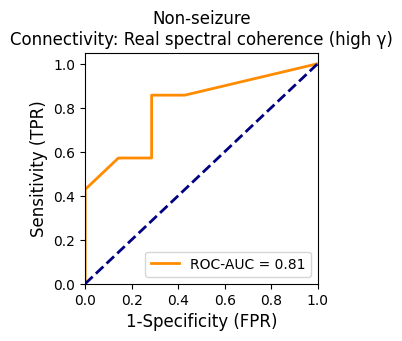

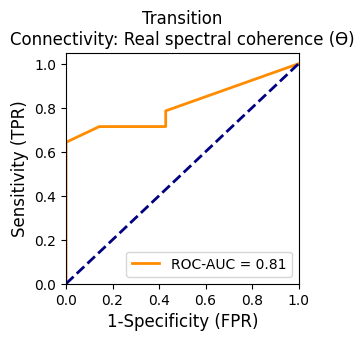

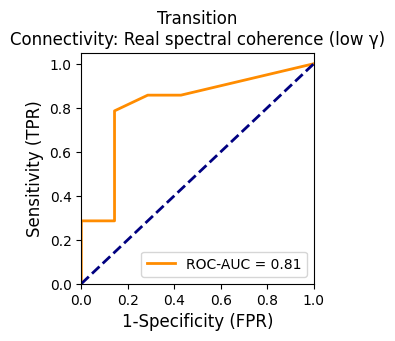

In [12]:
results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder+"results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    # Store the results in a list


    for cm in conn_measures:

        data = load_data.groupby("method").get_group(cm)

        scores, actual_labels = list(data.score1), list(data.outcome)

        # Calculate the ROC curve
        fpr, tpr, thresholds = roc_curve(actual_labels, scores)

        # Calculate the AUC
        roc_auc = auc(fpr, tpr)

        # Compute Youden's index
        youden_index = tpr - fpr
        best_threshold_index = np.argmax(youden_index)

        # Sensitivity and specificity at the best threshold
        sens = tpr[best_threshold_index]
        spec = 1 - fpr[best_threshold_index]

        # Print the AUC
        # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

        # Append the results to the list
        results.append({
            'WOI': woi,
            'CM': cm,
            'AUC': roc_auc,
            'Sensitivity': sens,
            'Specificity': spec
        })

        # Plot the ROC curve
        if roc_auc > 0.8:

          woi_str = ''
          if woi=="NS": woi_str = "Transition"
          elif woi=="N60S": woi_str = "Pre-seizure"
          elif woi=="NE": woi_str = "Seizure"
          elif woi=="NN": woi_str = "Non-seizure"

          cm_str = substitute_cm(cm)
          cm_str = substitute_bands(cm_str)

          plt.figure(figsize=(3,3))
          plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
          plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
          plt.xlim([0.0, 1.0])
          plt.ylim([0.0, 1.05])
          plt.xlabel('1-Specificity (FPR)', size=12)
          plt.ylabel('Sensitivity (TPR)', size=12)
          plt.title(f'{woi_str}\nConnectivity: {cm_str}')
          plt.legend(loc="lower right")
          plt.show()
          plt.close()

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Save the results to an Excel file
    # results_df.to_excel(main_folder + "1cm_rocauc_results.xlsx", index=False)

Combinations od 2 connectivity measures:

In [ ]:
# Function to compute AUC, sensitivity, and specificity for a given combination of connectivity measures
def compute_metrics_for_combination(cm_combination, load_data):

    combined_scores = []
    actual_labels = None

    for cm in cm_combination:

        data = load_data[load_data['method'] == cm]
        if data['score1'].values.shape[0] == 21:
          if actual_labels is None:
              actual_labels = data['outcome'].values
          combined_scores.append(data['score1'].values)
        else: break

    if len(combined_scores) == len(cm_combination):

      avg_scores = np.mean(combined_scores, axis=0)
      fpr, tpr, thresholds = roc_curve(actual_labels, avg_scores)
      roc_auc = auc(fpr, tpr)

      # Compute Youden's index
      youden_index = tpr - fpr
      best_threshold_index = np.argmax(youden_index)

      # Sensitivity and specificity at the best threshold
      sens = tpr[best_threshold_index]
      spec = 1 - fpr[best_threshold_index]

      return roc_auc, sens, spec

    else: return None, None, None

WOI: NN


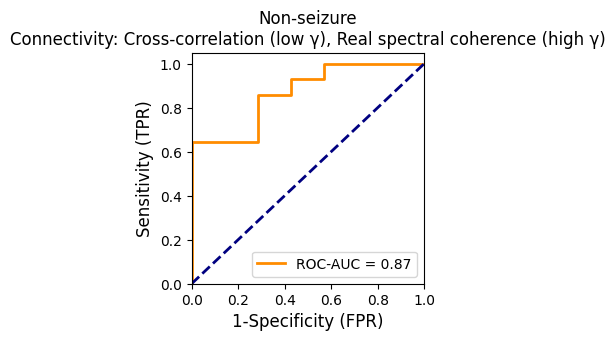

WOI: NS


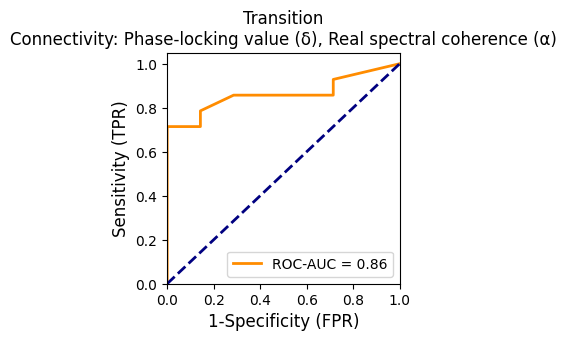

WOI: NS


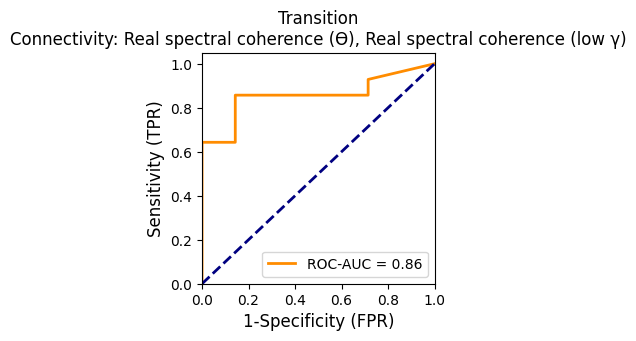

WOI: NS


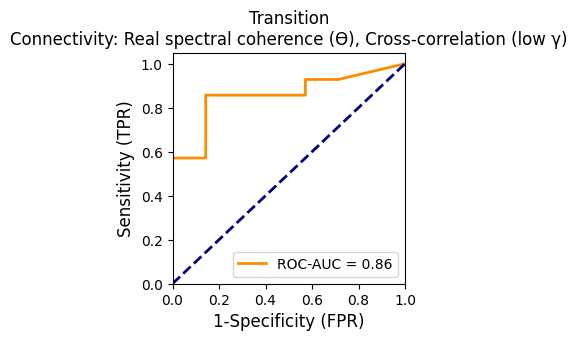

In [15]:
# Generate combinations of 2 connectivity measures

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures, 2):

        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:
          # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

          combination_str = ', '.join(cm_combination)
          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve

          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.85:

            woi_str = ''
            if woi=="NS": woi_str = "Transition"
            elif woi=="N60S": woi_str = "Pre-seizure"
            elif woi=="NE": woi_str = "Seizure"
            elif woi=="NN": woi_str = "Non-seizure"

            cm_str = substitute_cm(combination_str)
            cm_str = substitute_bands(cm_str)

            plt.figure(figsize=(3,3))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('1-Specificity (FPR)', size=12)
            plt.ylabel('Sensitivity (TPR)', size=12)
            plt.title(f'{woi_str}\nConnectivity: {cm_str}')
            plt.legend(loc="lower right")
            plt.show()
            plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
# results_df.to_excel(main_folder + "2cm_rocauc_results.xlsx", index=False)

Combinations of 3 connectivity measures:

In [ ]:
# Generate combinations of 3 connectivity measures

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures, 3):
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:
          # print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.9:

            woi_str = ''
            if woi=="NS": woi_str = "Transition"
            elif woi=="N60S": woi_str = "Pre-seizure"
            elif woi=="NE": woi_str = "Seizure"
            elif woi=="NN": woi_str = "Non-seizure"

            cm_str = substitute_cm(combination_str)
            cm_str = substitute_bands(cm_str)

            plt.figure(figsize=(3,3))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('1-Specificity (FPR)', size=12)
            plt.ylabel('Sensitivity (TPR)', size=12)
            plt.title(f'{woi_str}\nConnectivity: {cm_str}')
            plt.legend(loc="lower right")
            plt.show()
            plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "3cm_rocauc_results.xlsx", index=False)

<ipython-input-25-1cd47e57083e>:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Combinations of 4 connectivity measures:

The AUC is: 0.8571428571428571, Sensitivity: 0.7857142857142857, Specificity: 0.8571428571428572


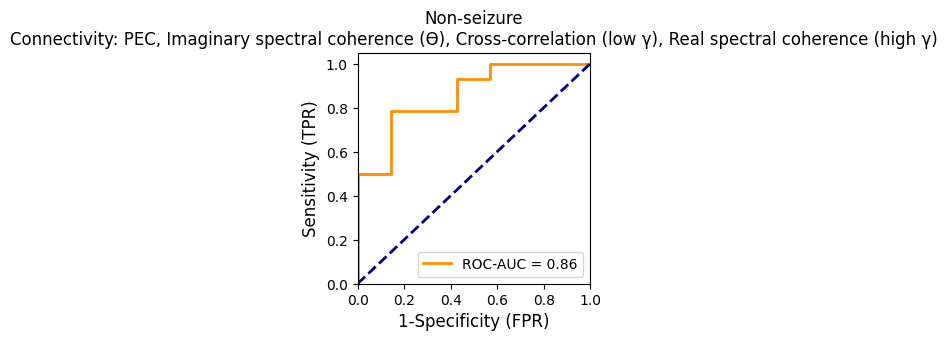

The AUC is: 0.8571428571428571, Sensitivity: 0.7142857142857143, Specificity: 1.0


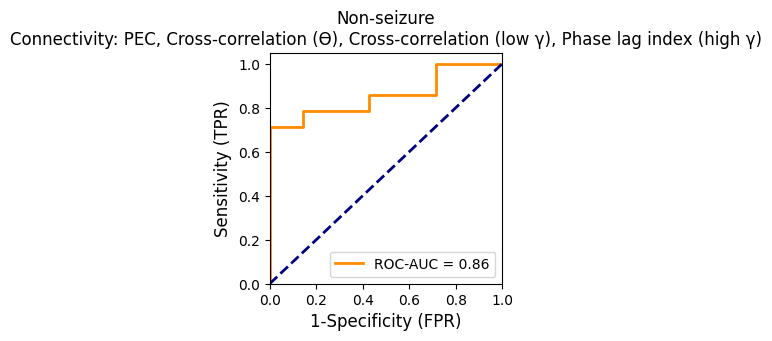

The AUC is: 0.8673469387755103, Sensitivity: 0.6428571428571429, Specificity: 1.0


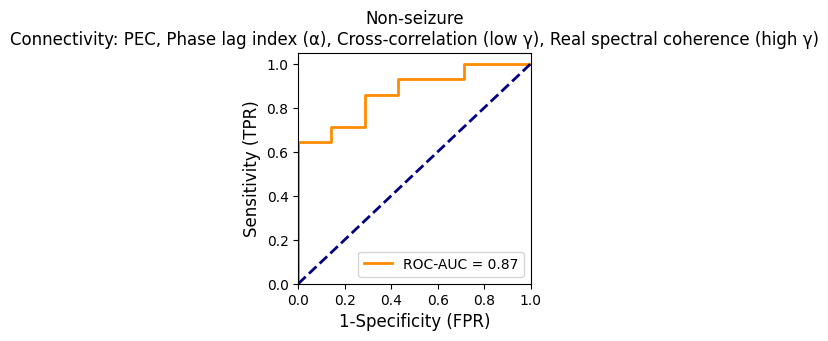

The AUC is: 0.8775510204081634, Sensitivity: 0.8571428571428571, Specificity: 0.8571428571428572


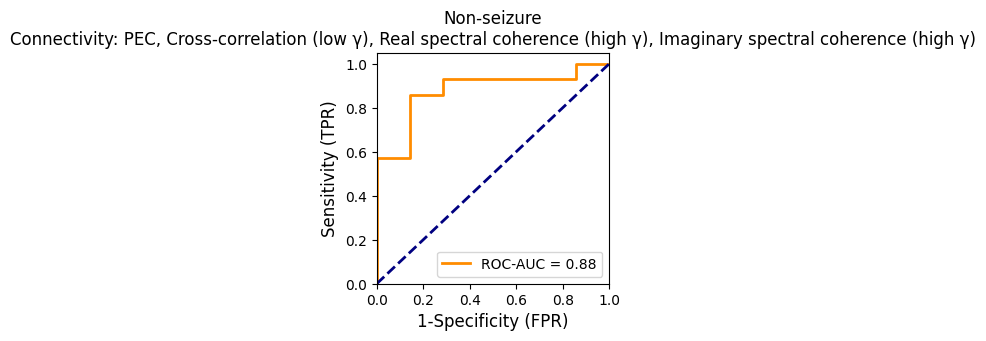

The AUC is: 0.8622448979591837, Sensitivity: 0.6428571428571429, Specificity: 1.0


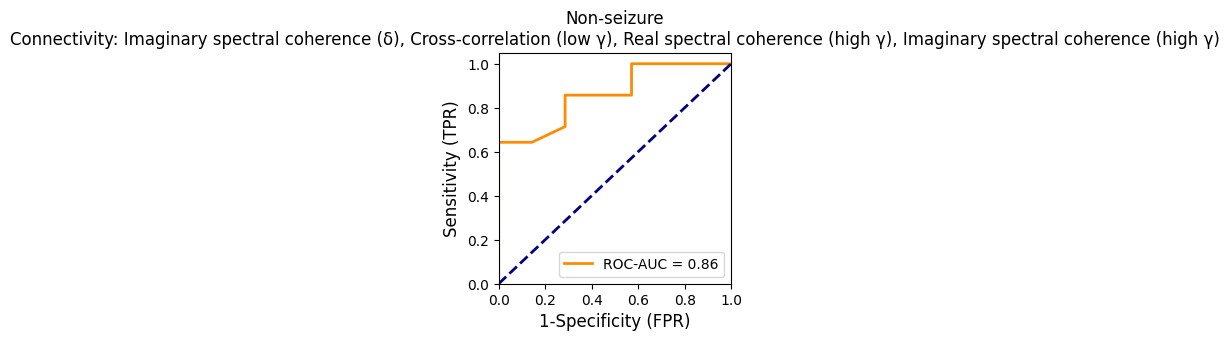

In [ ]:
# Generate combinations of 4 connectivity measures
# combinations = [('PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(30,70)'), ('PLI(1,4)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'), ('CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'CC(30,70)'),
# ('PEC', 'PAC', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PLI(1,4)', 'PLV(1,4)', 'CC(30,70)'),
# ('PEC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(1,4)'),
# ('PEC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(8,12)'),
# ('PEC', 'PLI(1,4)', 'PLV(4,8)', 'SC_R(1,4)'),
# ('PEC', 'PLI(1,4)', 'CC(13,30)', 'CC(30,70)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_I(70,150)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(1,4)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)'),
# ('PEC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(30,70)'),
# ('PEC', 'PLI(1,4)', 'SC_I(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(8,12)'),
# ('PEC', 'PLV(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PLV(70,150)', 'SC_I(1,4)', 'SC_R(30,70)'),
# ('PEC', 'CC(13,30)', 'CC(30,70)', 'SC_R(8,12)'),
# ('PEC', 'CC(30,70)', 'SC_I(70,150)', 'SC_R(30,70)'),
# ('PEC', 'CC(30,70)', 'SC_R(1,4)', 'SC_R(4,8)')]

results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures,4):
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.85:

              print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

              woi_str = ''
              if woi=="NS": woi_str = "Transition"
              elif woi=="N60S": woi_str = "Pre-seizure"
              elif woi=="NE": woi_str = "Seizure"
              elif woi=="NN": woi_str = "Non-seizure"

              cm_str = substitute_cm(combination_str)
              cm_str = substitute_bands(cm_str)

              plt.figure(figsize=(3,3))
              plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
              plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
              plt.xlim([0.0, 1.0])
              plt.ylim([0.0, 1.05])
              plt.xlabel('1-Specificity (FPR)', size=12)
              plt.ylabel('Sensitivity (TPR)', size=12)
              plt.title(f'{woi_str}\nConnectivity: {cm_str}')
              plt.legend(loc="lower right")
              plt.show()
              plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "4cm_rocauc_results.xlsx", index=False)

Combinations of 5 connectivity measures:

In [ ]:
# Generate combinations of 5 connectivity measures
# combinations = [('PEC', 'PLI(1,4)', 'SC_I(8,12)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PAC', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PLI(1,4)', 'PLV(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PLI(1,4)', 'PLV(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(30,70)'),
# ('PLI(1,4)', 'PLV(1,4)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PLI(1,4)', 'CC(30,70)', 'SC_I(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'PLV(1,4)', 'CC(30,70)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'PLV(1,4)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'CC(30,70)', 'SC_R(4,8)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_I(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_R(1,4)', 'SC_R(4,8)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'PLI(1,4)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'PLV(1,4)', 'CC(30,70)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'PLV(70,150)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'CC(30,70)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PAC', 'CC(30,70)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'SC_I(30,70)', 'SC_R(8,12)', 'SC_R(30,70)'),
# ('PEC', 'PAC', 'SC_R(1,4)', 'SC_R(4,8)', 'SC_R(8,12)'),
# ('PEC', 'PLI(1,4)', 'PLI(70,150)', 'SC_I(1,4)', 'SC_R(4,8)')]


results = []

for woi in ["NN","N60S","NS","NE"]:

    load_data = pd.read_excel(main_folder + "results.xlsx", engine='openpyxl')
    if woi=="NN": load_data = pd.read_excel(main_folder+"results-nn.xlsx", engine='openpyxl')
    load_data = load_data[load_data['time_frame'] == woi]

    for cm_combination in itertools.combinations(conn_measures, 5):
        combination_str = ', '.join(cm_combination)
        roc_auc, sens, spec = compute_metrics_for_combination(cm_combination, load_data)

        if roc_auc != None:

          # Append the results to the list
          results.append({
              'WOI': woi,
              'CM': combination_str,
              'AUC': roc_auc,
              'Sensitivity': sens,
              'Specificity': spec
          })

          # Plot the ROC curve
          combined_scores = []
          actual_labels = None
          for cm in cm_combination:
              data = load_data[load_data['method'] == cm]
              if actual_labels is None:
                  actual_labels = data['outcome'].values
              combined_scores.append(data['score1'].values)
          avg_scores = np.mean(combined_scores, axis=0)
          fpr, tpr, _ = roc_curve(actual_labels, avg_scores)

          if roc_auc > 0.8:

              print(f'The AUC is: {roc_auc}, Sensitivity: {sens}, Specificity: {spec}')

              woi_str = ''
              if woi=="NS": woi_str = "Transition"
              elif woi=="N60S": woi_str = "Pre-seizure"
              elif woi=="NE": woi_str = "Seizure"
              elif woi=="NN": woi_str = "Non-seizure"

              cm_str = substitute_cm(combination_str)
              cm_str = substitute_bands(cm_str)

              plt.figure(figsize=(3,3))
              plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:0.2f}')
              plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
              plt.xlim([0.0, 1.0])
              plt.ylim([0.0, 1.05])
              plt.xlabel('1-Specificity (FPR)', size=12)
              plt.ylabel('Sensitivity (TPR)', size=12)
              plt.title(f'{woi_str}\nConnectivity: {cm_str}')
              plt.legend(loc="lower right")
              plt.show()
              plt.close()

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to an Excel file
results_df.to_excel(main_folder + "5cm_rocauc_results.xlsx", index=False)

In [ ]:
import seaborn as sns

wois=["NN","N60S","NS","NE"]

xd,yd,hue=[],[],[]

for woi in wois:

    for it in range(1,6):

        f = "{}cm_rocauc_results.xlsx".format(it)

        df = pd.read_excel(main_folder+f)
        df = df[['time_frame'] == woi]
        ytemp=list(df["AUC"])
        yd+=list(ytemp)
        xd+=[str(it)]*len(ytemp)

        if woi=="NS": hue+=["transition"]*len(ytemp)
        elif woi=="N60S": hue+=["pre-seizure"]*len(ytemp)
        elif woi=="NE": hue+=["seizure"]*len(ytemp)
        elif woi=="NN": hue+=["non-seizure"]*len(ytemp)

datasorted = {"xd":xd,
      "hue_woi":hue,
      "yd":yd}

# bp=sns.boxplot(y="overlap", x="tick", data=data, palette="colorblind", width=0.5)
bp=sns.boxplot(y="yd", x="xd", data=datasorted, hue="hue_woi", palette="colorblind")

handles, labels = bp.get_legend_handles_labels()
plt.legend(handles[0:len(wois)], labels[0:len(wois)], fontsize=24,bbox_to_anchor=(1.05, 1))
# plt.title("Network overlap", size=24)
plt.yticks(fontsize=24,rotation=90)
plt.xticks(fontsize=24)
plt.ylabel('ROC-AUC',fontsize=28)
plt.xlabel('Multiscore combination size',fontsize=28)

In [ ]:
wois=["NN","N60S","NS","NE"]

xd,yd,hue=[],[],[]

for woi in wois:

    for it in range(1,6):

        f = "{}cm_rocauc_results.xlsx".format(it)

        df = pd.read_excel(main_folder+f)
        df = df[['time_frame'] == woi]

        df_max = df[df['AUC']==df['AUC'].max()]

        ytemp=list(df_max["AUC"])
        yd+=list(ytemp)
        xd+=[str(it)]*len(ytemp)

        if woi=="NS": hue+=["transition"]*len(ytemp)
        elif woi=="N60S": hue+=["pre-seizure"]*len(ytemp)
        elif woi=="NE": hue+=["seizure"]*len(ytemp)
        elif woi=="NN": hue+=["non-seizure"]*len(ytemp)

datasorted = {"xd":xd,
      "hue_woi":hue,
      "yd":yd}

# bp=sns.boxplot(y="overlap", x="tick", data=data, palette="colorblind", width=0.5)
bp=sns.scatterplot(y="yd", x="xd", data=datasorted, hue="hue_woi", palette="colorblind")
bp=sns.lineplot(y="yd", x="xd", data=datasorted, hue="hue_woi", palette="colorblind")

handles, labels = bp.get_legend_handles_labels()
plt.legend(handles[0:len(wois)], labels[0:len(wois)], fontsize=24,bbox_to_anchor=(1.05, 1))
# plt.title("Network overlap", size=24)
plt.yticks(fontsize=24,rotation=90)
plt.xticks(fontsize=24)
plt.ylabel('ROC-AUC',fontsize=28)
plt.xlabel('Multiscore combination size',fontsize=28)